# Linear Classification with Softmax Loss

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import time
import random
import math
import numpy as np
from dl4cv.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

To your convenience, we have taken care of all the input handling. Nevertheless, you should go through the code line by line so that you understand the general preprocessing pipeline.
The whole datasat is loaded, then subdivided into a training, validation and test dataset (the last one is different from the final evaluation dataset on our server!).
Before proceeding you should *always* take a look at some samples of your dataset, which is already implemented for you. This way you can make sure that the data input/preprocessing has worked as intended and you can get a feeling for the dataset.

In [2]:
from dl4cv.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/'
X, y = load_CIFAR10(cifar10_dir)

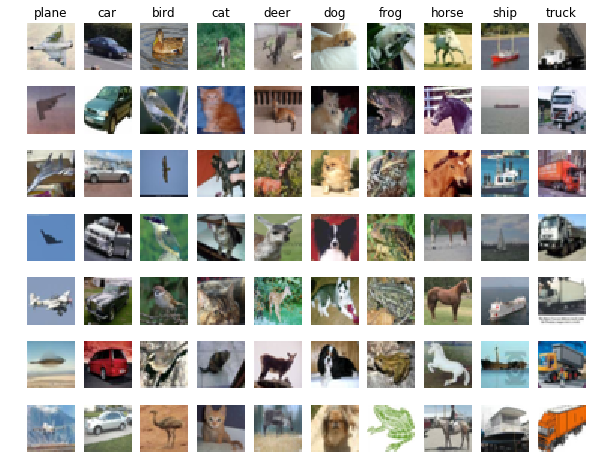

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X[mask]
y_train = y[mask]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (48000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64297917  135.92841667  132.4100625   130.0744375   135.3130625
  131.70479167  131.0373125   136.18741667  132.48804167  131.65420833]


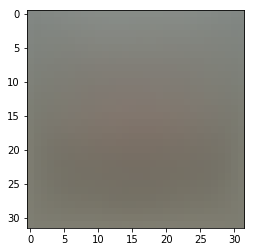

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(48000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

Your code for this section will all be written inside `dl4cv/classifiers/softmax.py`. 
You will implement the gradient of the loss function with respect to the classifier's weights. We suggest that you first derive these expressions on paper.

### Naive Implementation
First implement the naive softmax loss function with nested loops.
Open the file `dl4cv/classifiers/softmax.py` and implement the softmax_loss_naive function.
Running this method might take a while...

In [9]:
from dl4cv.classifiers.softmax import softmax_loss_naive

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.427974
sanity check: 2.302585


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Why do we expect our loss to be close to -log(0.1)? Explain briefly.</p>
</div>

CIFAR 10 has 10 classes and we initialize the weights randomly. Without training we expect the result to be around 0.1. Since the loss function is - log(x) we can expect a loss of -log(.1)

In [10]:
#from dl4cv.classifiers.softmax import softmax_loss_vectorized
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from dl4cv.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Again, running this might take a while!

numerical: 0.838238 analytic: 0.838238, relative error: 5.112005e-10
numerical: 0.410686 analytic: 0.410686, relative error: 7.633496e-08
numerical: 1.454253 analytic: 1.454253, relative error: 1.353779e-08
numerical: 0.664346 analytic: 0.668383, relative error: 3.028513e-03
numerical: -2.975565 analytic: -2.972983, relative error: 4.341422e-04
numerical: -1.526643 analytic: -1.518853, relative error: 2.557862e-03


### Vectorized Implementation
Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized.
The two versions should compute the same results, but the vectorized version should be much faster.

In [11]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from dl4cv.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.427974e+00 computed in 21.770816s
vectorized loss: 2.427974e+00 computed in 0.003468s
Loss difference: 0.000000
Gradient difference: 0.000000


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>When you compute the softmax distribution, you are dividing by a sum of exponentials, i.e. potentially very large numbers, which can be numerically unstable. Do you see a way to avoid this problem?
</p>
    <p>(Hint: exploit properties of the exponential function to arrive at an expression that is mathematically the same, but numerically more stable)</p>
</div>

We can subtract the max before performing the calculation to get the softmax. By doing this the max result will be 0 but since we normalize to [0, 1] anyway this makes no difference since we scale each value by the same ammount

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [56]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from dl4cv.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=0.0000004, reg=2500,
                      num_iters=2000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 2000: loss 84.254772
iteration 100 / 2000: loss 66.344546
iteration 200 / 2000: loss 54.230676
iteration 300 / 2000: loss 44.342323
iteration 400 / 2000: loss 36.512294
iteration 500 / 2000: loss 30.099425
iteration 600 / 2000: loss 24.728568
iteration 700 / 2000: loss 20.588581
iteration 800 / 2000: loss 17.058798
iteration 900 / 2000: loss 14.305329
iteration 1000 / 2000: loss 12.004426
iteration 1100 / 2000: loss 10.301734
iteration 1200 / 2000: loss 8.692336
iteration 1300 / 2000: loss 7.381042
iteration 1400 / 2000: loss 6.501765
iteration 1500 / 2000: loss 5.534595
iteration 1600 / 2000: loss 4.872689
iteration 1700 / 2000: loss 4.405495
iteration 1800 / 2000: loss 3.918689
iteration 1900 / 2000: loss 3.463502
That took 6.984153s


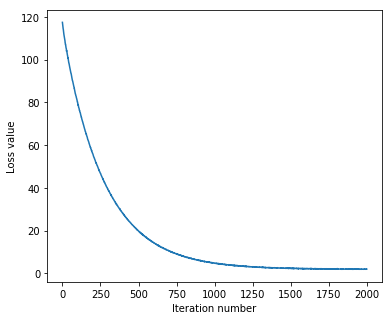

In [32]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [57]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.393417
validation accuracy: 0.399000


### Training your Softmax Classifier
Use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set.

In [59]:
from dl4cv.classifiers import Softmax

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1
best_softmax = None
all_classifiers = []
learning_rates = [1e-7, 2e-7, 4e-7]
regularization_strengths = [1e-4, 500, 2500]

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a classifier on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this    #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train;       # 
# once you are confident that your validation code works, you should rerun     #
# the validation code with a larger value for num_iters.                       #
################################################################################

# perform a grid search to find 'optimal' hyperparameters
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        # train to get loss and accuracy
        softmax = Softmax()
        print('Train with learning rate {0} and regularization {1}'.format(learning_rate, regularization_strength))
        loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength,
                      num_iters=2500, verbose=True)
        y_train_pred = np.mean(y_train == softmax.predict(X_train))
        y_val_pred = np.mean(y_val == softmax.predict(X_val))     
        results[(learning_rate, regularization_strength)] = (y_train_pred, y_val_pred)
        all_classifiers.append((softmax, y_val_pred))
        
        # save if best        
        if y_val_pred > best_val:
            print(':) BEST Validation Accuracy: ', y_val_pred)
            best_val = y_val_pred
            best_softmax = softmax

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for (lr, reg) in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

Train with learning rate 1e-07 and regularization 0.0001
iteration 0 / 2500: loss 7.040659
iteration 100 / 2500: loss 4.013239
iteration 200 / 2500: loss 3.328801
iteration 300 / 2500: loss 3.321993
iteration 400 / 2500: loss 3.335280
iteration 500 / 2500: loss 3.122797
iteration 600 / 2500: loss 3.128293
iteration 700 / 2500: loss 2.809620
iteration 800 / 2500: loss 2.929625
iteration 900 / 2500: loss 3.192489
iteration 1000 / 2500: loss 2.638589
iteration 1100 / 2500: loss 2.950732
iteration 1200 / 2500: loss 2.631717
iteration 1300 / 2500: loss 2.651766
iteration 1400 / 2500: loss 2.607913
iteration 1500 / 2500: loss 2.680931
iteration 1600 / 2500: loss 2.776719
iteration 1700 / 2500: loss 2.568120
iteration 1800 / 2500: loss 2.640228
iteration 1900 / 2500: loss 2.459107
iteration 2000 / 2500: loss 2.461128
iteration 2100 / 2500: loss 2.537894
iteration 2200 / 2500: loss 2.494406
iteration 2300 / 2500: loss 2.449688
iteration 2400 / 2500: loss 2.392592
:) BEST Validation Accuracy:  

iteration 200 / 2500: loss 53.362439
iteration 300 / 2500: loss 43.675617
iteration 400 / 2500: loss 35.939670
iteration 500 / 2500: loss 29.796238
iteration 600 / 2500: loss 24.480914
iteration 700 / 2500: loss 20.360572
iteration 800 / 2500: loss 16.962560
iteration 900 / 2500: loss 14.166433
iteration 1000 / 2500: loss 11.993046
iteration 1100 / 2500: loss 10.135007
iteration 1200 / 2500: loss 8.529213
iteration 1300 / 2500: loss 7.319971
iteration 1400 / 2500: loss 6.324641
iteration 1500 / 2500: loss 5.449539
iteration 1600 / 2500: loss 4.896981
iteration 1700 / 2500: loss 4.295880
iteration 1800 / 2500: loss 3.900407
iteration 1900 / 2500: loss 3.534027
iteration 2000 / 2500: loss 3.208659
iteration 2100 / 2500: loss 2.999895
iteration 2200 / 2500: loss 2.837995
iteration 2300 / 2500: loss 2.692862
iteration 2400 / 2500: loss 2.458239
:) BEST Validation Accuracy:  0.393
lr 1.000000e-07 reg 1.000000e-04 train accuracy: 0.272292 val accuracy: 0.286000
lr 1.000000e-07 reg 5.000000e+

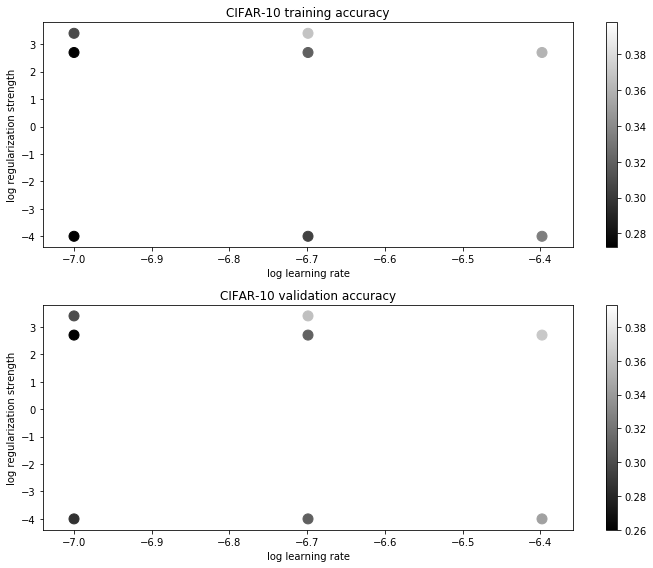

In [60]:
# Visualize the validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [61]:
# if you want to take a look at the other classifiers assign them to best_softmax here
sorted_classifiers = sorted(all_classifiers, key=lambda x : x[1])
best_softmax = sorted_classifiers[-1][0]

In [62]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.407000


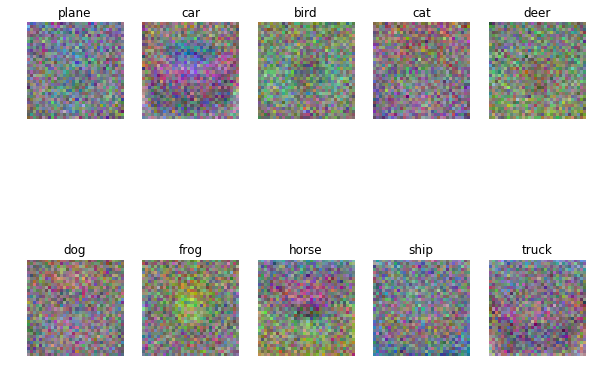

In [63]:
# Visualize the learned weights for each class
#best_softmax = sorted_classifiers[idx][0]
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe what your visualized Softmax weights look like.</p>
</div>

They contain a lot of noise which makes sense since it's only a trivial linear classifier. However, in some cases basic shapes can be seen (e.g. car, frog or horse)

## Save the model

When you are satisfied with your training, save the model for submission.

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle `<class 'dl4cv.classifiers.linear_classifier.Softmax'>`: it's not the same object as dl4cv.classifiers.linear_classifier.Softmax</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [64]:
from dl4cv.model_savers import save_softmax_classifier
from dl4cv.classifiers import Softmax

save_softmax_classifier(best_softmax)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.38 \\
        \left(\frac{38}{\exp(0.38 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.38 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

Final score:  45.82069745224887


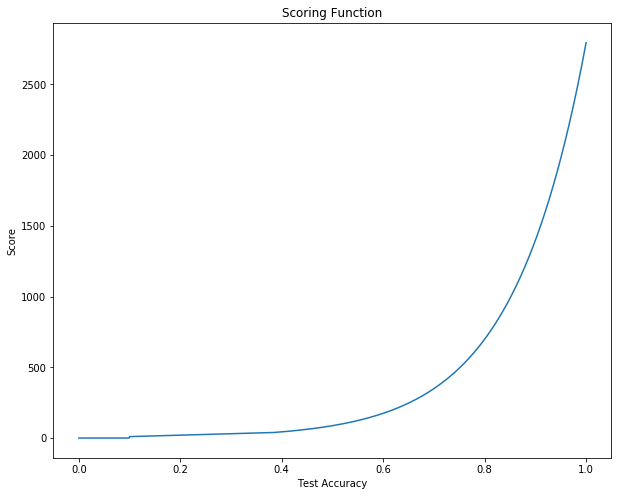

In [65]:
from dl4cv.data_utils import scoring_function
print('Final score: ',scoring_function(test_accuracy, lin_exp_boundary=0.38, doubling_rate=0.1))
x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.38, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()